### Inserting Libraries

In [1]:
import spotipy
import credentials
from tqdm import tqdm_notebook as tqdm
from spotipy.oauth2 import SpotifyClientCredentials, is_token_expired
import pandas as pd

### Setting up API credentials

In [2]:
# You should create a credentials.py in your repo with credentials in it

In [3]:
client_credentials_manager = SpotifyClientCredentials(client_id=credentials.client_id,client_secret=credentials.client_secret)

In [4]:
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### Function that given a user_id returns all the data

In [41]:
def get_all_data(user_id):
    
    #get all the playlist id's
    
    track_list = []
    sname_list = []
    artist_list = []
    audio_ft = []
    
        
    for playlist in tqdm(sp.user_playlists(user_id)['items']):
            for idx,track in enumerate(sp.playlist_tracks(playlist['id'])['items']):
                if track['track']['id'] is not None:
                    
                    track_list.append(track['track']['id'])
                    sname_list.append(track['track']['name'])
                    artist_list.append(track['track']['album']['artists'][0])
                    #print(track['track']['id'])
                    audio_ft.append(sp.audio_features(track['track']['id'])[0])
    
    df = pd.DataFrame({'name': sname_list,
                       'artist': artist_list,
                       'id': track_list,
                       'audio_ft': audio_ft})
    
    return df

            

In [42]:
df = get_all_data('11101312700')

/home/tomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [7]:
# Time to transform the data in order to be clean

In [43]:
def transform_data(df):
    
    df['artist'] = df['artist'].apply(pd.Series)['name']
    
    df = pd.concat([df,df['audio_ft'].apply(pd.Series)], axis=1)
    
    df = df.drop(labels=['time_signature','duration_ms','analysis_url','uri','track_href','type','audio_ft'], axis=1)
    
    return df
    
    
    

In [44]:
df = transform_data(df)

In [45]:
df.head()

,name,artist,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id
0,Brokendate,Com Truise,2kmX8QNMLg72Vy9Ux6mdmi,0.526,0.544,11,-7.137,1,0.1690,0.25800,0.640000,0.3770,0.544,170.370,2kmX8QNMLg72Vy9Ux6mdmi
1,Crimewave,Crystal Castles,3yQFmN8A5S8Kf1nUJuvb01,0.746,0.691,4,-7.533,0,0.0403,0.18400,0.025900,0.2050,0.888,119.982,3yQFmN8A5S8Kf1nUJuvb01
2,Vanished,Crystal Castles,0exOxvY3iHsmAnGHiJYAZq,0.713,0.868,0,-6.644,0,0.0305,0.00206,0.000092,0.2250,0.641,119.980,0exOxvY3iHsmAnGHiJYAZq
3,Lady - Hear Me Tonight,Modjo,49X0LAl6faAusYq02PRAY6,0.720,0.808,6,-5.627,1,0.0379,0.00793,0.029300,0.0634,0.869,126.041,49X0LAl6faAusYq02PRAY6
4,Baby I'm Yours,Breakbot,0tZkVZ9DeAa0MNK2gY5NtV,0.829,0.792,2,-3.755,0,0.0668,0.72600,0.000006,0.1220,0.758,118.050,0tZkVZ9DeAa0MNK2gY5NtV


Now we have all the songs of our playlist in a data frame with each audio feature, time to do some magic

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [145]:
features = ['danceability','energy','acousticness'
           ,'instrumentalness','valence']

In [146]:
scaler = MinMaxScaler()

scaled = pd.DataFrame(scaler.fit_transform(df[features]))
scaled.columns = features


In [147]:
def calculate_wcss(data):
    wcss = []
    for n in range(1, 15):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

In [148]:
wcss = calculate_wcss(scaled)

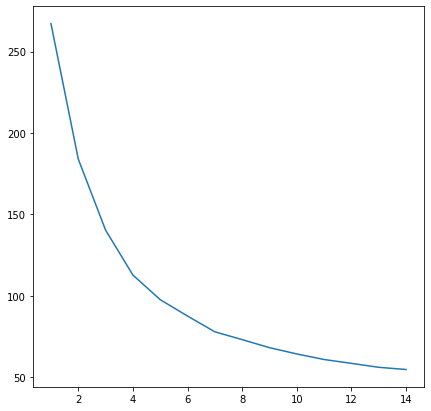

In [149]:
sns.lineplot(x=range(1,15), y=wcss)

In [150]:
kmeans = KMeans(n_clusters=5).fit(scaled)

In [151]:
y_kmeans = kmeans.predict(scaled)

In [152]:
centroids = kmeans.cluster_centers_
centroids

array([[0.52429512, 0.68624693, 0.10023413, 0.02968815, 0.30491643],
       [0.55692459, 0.35923053, 0.66431342, 0.81312859, 0.23009845],
       [0.53388311, 0.38600316, 0.68187805, 0.02621492, 0.32502039],
       [0.66449134, 0.7485716 , 0.13575771, 0.01690705, 0.71107099],
       [0.6244338 , 0.69465741, 0.08514106, 0.79821181, 0.54679819]])

In [153]:
scaled = scaler.fit_transform(scaled)

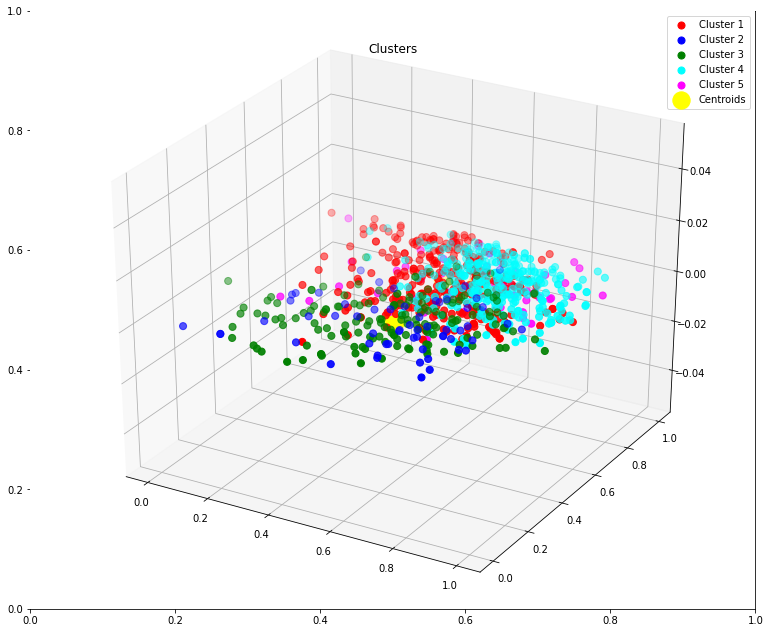

In [154]:
from mpl_toolkits.mplot3d import Axes3D
# visualizing clusters
fig, ax = plt.subplots(figsize=(13,11))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(scaled[y_kmeans == 0,0],scaled[y_kmeans == 0,1], s= 50, c= 'red',label= 'Cluster 1')
plt.scatter(scaled[y_kmeans == 1,0], scaled[y_kmeans == 1,1], s= 50, c= 'blue', label= 'Cluster 2')
plt.scatter(scaled[y_kmeans == 2,0], scaled[y_kmeans == 2,1], s= 50, c= 'green', label= 'Cluster 3')
plt.scatter(scaled[y_kmeans == 3,0], scaled[y_kmeans == 3,1], s= 50, c= 'cyan', label= 'Cluster 4')
plt.scatter(scaled[y_kmeans == 4,0], scaled[y_kmeans == 4,1], s= 50, c= 'magenta', label= 'Cluster 5')


# centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s= 300, c= 'yellow', label= 'Centroids')
plt.title('Clusters')
plt.legend()
plt.show()

In [155]:
kmeans_pred = pd.DataFrame(data=y_kmeans, dtype=int, columns=['k_cluster'])
kmeans_pred

,k_cluster
0,4
1,3
2,3
3,3
4,3
...,...
872,3
873,3
874,3
875,2


In [156]:
df_cluster = pd.concat([df, kmeans_pred], axis = 1)

In [158]:
labels = cluster_0.index
stats = cluster_0.values

In [159]:
cluster_stats = pd.DataFrame(columns=features)
for n in range(5):   
    cluster_stats = cluster_stats.append(df_cluster[df_cluster.k_cluster == n][features].mean(), ignore_index=True)
       

In [160]:
cluster_stats_scaled = pd.DataFrame(scaler.fit_transform(cluster_stats))
cluster_stats_scaled.columns = features
cluster_stats

,danceability,energy,acousticness,instrumentalness,valence
0,0.536912,0.690166,0.099435,0.028501,0.322937
1,0.566207,0.374529,0.659000,0.780603,0.252212
2,0.545520,0.400370,0.676424,0.025166,0.341942
3,0.662780,0.750321,0.134674,0.016231,0.706875
4,0.626817,0.698283,0.084463,0.766283,0.551588


In [161]:
cluster_stats_scaled

,danceability,energy,acousticness,instrumentalness,valence
0,0.000000,0.839923,0.025293,0.016052,0.155556
1,0.232741,0.000000,0.970566,1.000000,0.000000
2,0.068390,0.068764,1.000000,0.011690,0.197354
3,1.000000,1.000000,0.084822,0.000000,1.000000
4,0.714275,0.861525,0.000000,0.981266,0.658457


In [162]:
from math import pi

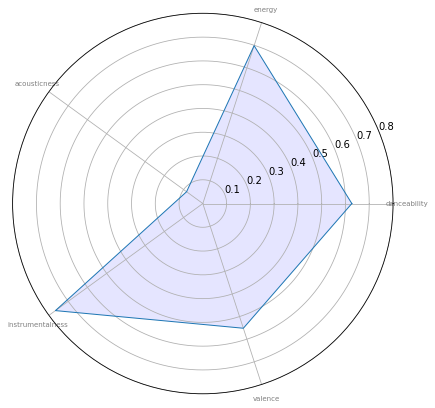

In [163]:
categories = list(cluster_stats)
N = len(categories)


values = cluster_stats.loc[4].values.flatten().tolist()
values += values[:1]


angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1], categories, color='grey', size=7)

ax.plot(angles, values, linewidth=1, linestyle='solid')

ax.fill(angles,values, 'b', alpha=0.1)

In [166]:
def make_spider(row, title, color):
    #number of variable
    
    categories=list(cluster_stats)
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    #initialize spider
    ax = plt.subplot(2,3,row+1,polar=True)
    
    ax.set_theta_offset(pi/2)
    ax.set_theta_direction(-1)
                
    plt.xticks(angles[:-1], categories, color='grey', size=7)
    plt.ylim(0,1)
                
    #
    values=cluster_stats.loc[row].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    
    #title
    plt.title(title, size=11, color=color, y=1.1)

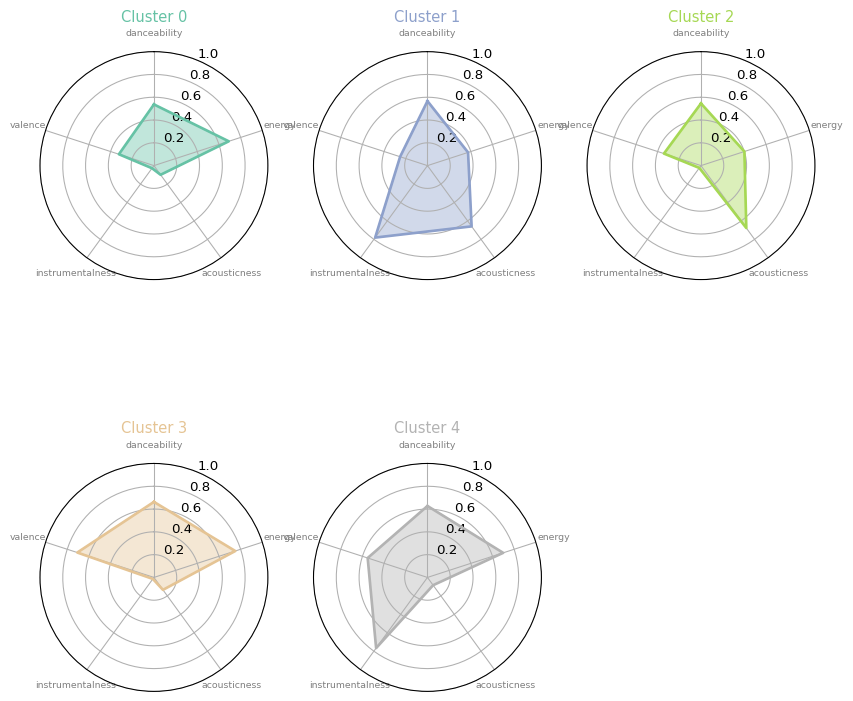

In [167]:
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

my_palette = plt.cm.get_cmap("Set2", len(cluster_stats_scaled.index))

for row in range(0, len(cluster_stats_scaled.index)):
    make_spider(row=row, title='Cluster {}'.format(row), color=my_palette(row))

In [170]:
df_cluster[df_cluster.k_cluster==0]['artist'].value_counts()

Red Hot Chili Peppers                      16
Arctic Monkeys                             12
Lil Peep                                    9
Eminem                                      9
Patricio Rey y sus Redonditos de Ricota     8
                                           ..
Ciro y los Persas                           1
Scarface                                    1
The Shins                                   1
Bjonr                                       1
Callejeros                                  1
Name: artist, Length: 149, dtype: int64

In [171]:
df_cluster[df_cluster.k_cluster==3]['artist'].value_counts()

Patricio Rey y sus Redonditos de Ricota    19
Arctic Monkeys                             17
Eminem                                     11
Red Hot Chili Peppers                       9
Homer El Mero Mero                          8
                                           ..
The Killers                                 1
Geto Boys                                   1
Ciro y los Persas                           1
Mick Jagger                                 1
Breakbot                                    1
Name: artist, Length: 142, dtype: int64

In [172]:
df_cluster[df_cluster.k_cluster==1]['artist'].value_counts()

Pink Floyd              5
Various Artists         4
Secession Studios       3
consule                 2
Bonjr                   2
Safakash                2
Hans Zimmer             2
Voyageur                2
Otaam                   1
fugue                   1
Chopsticks              1
Dreamhop Music          1
Kicktracks              1
Photay                  1
South Side Symphony     1
Two Steps from Hell     1
Sarah Schachner         1
CaliCronk               1
Jack Stauber            1
Italics                 1
Daft Punk               1
Black Monk              1
Broken Pupil            1
Fthmlss                 1
Timmies                 1
Bonobo                  1
Sexy Pigeon             1
Oh, My.                 1
Hevi                    1
Artemis Orion           1
Sarcastic Sounds        1
Soran Leif              1
Mounika.                1
FRANZ                   1
Music Lab Collective    1
Visceral Beats          1
Adam Youngman           1
Fully Bold              1
Nathan Lanie

In [173]:
df_cluster[df_cluster.k_cluster==2]['artist'].value_counts()

John Frusciante       6
The Rolling Stones    5
XXXTENTACION          5
Mac Miller            5
Bardero$              4
                     ..
Fulkost               1
Phora                 1
Last Day in Oasis     1
Tayrn                 1
sad face.             1
Name: artist, Length: 108, dtype: int64

In [174]:
df_cluster[df_cluster.k_cluster==4]['artist'].value_counts()

David Cutter Music              7
The Glitch Mob                  3
Soda Stereo                     3
The Strokes                     2
John Frusciante                 2
Derlee                          2
Secession Studios               2
Andrew Applepie                 2
Red Hot Chili Peppers           2
Safakash                        2
Joakim Karud                    2
Gorillaz                        2
Septimania                      1
Hans Zimmer                     1
Various Artists                 1
Peter Anderson                  1
Soviet Soviet                   1
deadmau5                        1
Acid Ghost                      1
MELVV                           1
Ninetoes                        1
Alok                            1
De Hofnar                       1
Martin Ikin                     1
9th Wonder                      1
Mtbrd                           1
Breakbot                        1
Baths                           1
Gaspar Narby                    1
Creedence Clea